In [19]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [20]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'VZ4PFOSZUC2DUO2R5GGH0JBUXXVJI43J3N0KLMDLN3ZPO01Z' # your Foursquare ID
CLIENT_SECRET = 'OVXVL31ZDSY02H4G3UIGVLZ1AU1NGXKQRSXUCNEUZTVNA1ZA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [21]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [22]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [23]:
ny_data.shape

(306, 4)

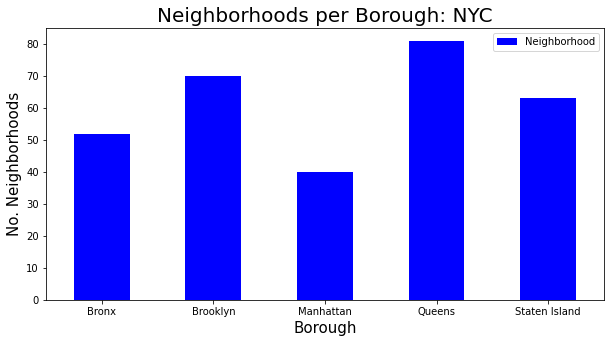

In [24]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [25]:
# queens has most neighborhoods
# prepare neighborhood list that contains yoga studios
column_names=['Borough', 'Neighborhood', 'ID','Name']
yoga_studio_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    yoga_studios=venues[venues['Category']=='Yoga Studio']   
    print('(',count,'/',len(ny_data),')','Yoga Studios in '+Neighborhood+', '+Borough+':'+str(len(yoga_studios)))
    print(row)
    for studio in yoga_studios.values.tolist():
        id, name , category=studio
        yoga_studio_ny = yoga_studio_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Yoga Studios in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Yoga Studios in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Yoga Studios in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Yoga Studios in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Yoga Studios in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Yoga Studios in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Yoga Studios in Marble Hill, Manhattan:1
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Yoga Studios in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Yoga Studios in Norwood, Bronx:0
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
( 10 /

( 72 / 306 ) Yoga Studios in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Yoga Studios in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Yoga Studios in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Yoga Studios in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Yoga Studios in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 / 306 ) Yoga Studios in Mill Island, Brooklyn:0
['Brooklyn', 'Mill Island', 40.606336421685626, -73.90818571777423]
( 78 / 306 ) Yoga Studios in Manhattan Beach, Brooklyn:0
['Brooklyn', 'Manhattan Beach', 40.57791350308657, -73.94353722891886]
( 79 / 306 ) Yoga Studios in Coney Island, Brooklyn:0
['Brooklyn', 'Coney Island', 40.57429256471601, -73.98868295821637]
( 80 / 306 ) Yoga Studios

KeyError: 'groups'

In [26]:
#yoga_studio_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
yoga_studio_ny.to_csv('yoga_studio_ny.csv')

In [39]:
yoga_studios_ny = pd.read_csv('yoga_studio_ny.csv', index_col=0)
yoga_studios_ny

,Borough,Neighborhood,ID,Name
0,Manhattan,Marble Hill,4baf59e8f964a520a6f93be3,Bikram Yoga
1,Brooklyn,Bay Ridge,4e8e41bf46907a17cc07a24d,Dahn Yoga
2,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga
3,Brooklyn,Greenpoint,55b51009498e4c7fd1fea655,New Love City
4,Brooklyn,Sheepshead Bay,4db0dc040437a93f7f7d4c16,Hot Spot Yoga
5,Brooklyn,Windsor Terrace,4c6b40eee13db60cf60ad4b1,Yoga Sole
6,Brooklyn,Prospect Heights,4ab80e06f964a520fe7b20e3,Shambhala Yoga and Dance Center
7,Brooklyn,Williamsburg,54a96fb3498ef8abe4184a51,Laughing Lotus Yoga Center
8,Brooklyn,Brooklyn Heights,4fa968b7e4b07cb43c311f1c,Area Yoga & Spa
9,Brooklyn,Brooklyn Heights,4a5ddf2cf964a520c8bd1fe3,Bikram Yoga Brooklyn Heights


In [40]:
yoga_studios_brooklyn = yoga_studios_ny[yoga_studios_ny['Borough']=='Brooklyn'].reset_index(drop=True)
yoga_studios_brooklyn

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,4e8e41bf46907a17cc07a24d,Dahn Yoga
1,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga
2,Brooklyn,Greenpoint,55b51009498e4c7fd1fea655,New Love City
3,Brooklyn,Sheepshead Bay,4db0dc040437a93f7f7d4c16,Hot Spot Yoga
4,Brooklyn,Windsor Terrace,4c6b40eee13db60cf60ad4b1,Yoga Sole
5,Brooklyn,Prospect Heights,4ab80e06f964a520fe7b20e3,Shambhala Yoga and Dance Center
6,Brooklyn,Williamsburg,54a96fb3498ef8abe4184a51,Laughing Lotus Yoga Center
7,Brooklyn,Brooklyn Heights,4fa968b7e4b07cb43c311f1c,Area Yoga & Spa
8,Brooklyn,Brooklyn Heights,4a5ddf2cf964a520c8bd1fe3,Bikram Yoga Brooklyn Heights
9,Brooklyn,Brooklyn Heights,59b1b5e12a7ab6050123b1d5,Heatwise


### Lets visualize the yoga studios that there are in the different neighborhoods.

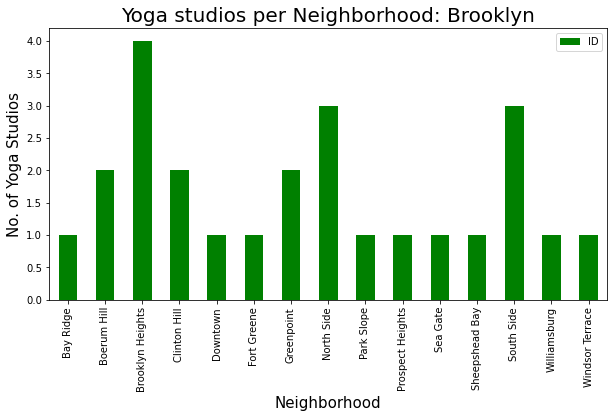

In [41]:
yoga_studios_brooklyn.groupby('Neighborhood')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Yoga studios per Neighborhood: Brooklyn', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Yoga Studios', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()

In [42]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in yoga_studios_brooklyn.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(yoga_studios_brooklyn),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5faec0a6e6b2a169842e7c9b'}, 'response': {'venue': {'id': '4e8e41bf46907a17cc07a24d', 'name': 'Dahn Yoga', 'contact': {}, 'location': {'address': '8206 3rd Ave', 'lat': 40.626273, 'lng': -74.030208, 'labeledLatLngs': [{'label': 'display', 'lat': 40.626273, 'lng': -74.030208}, {'label': 'entrance', 'lat': 40.626242, 'lng': -74.03008}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8206 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dahn-yoga/4e8e41bf46907a17cc07a24d', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'likes': {'count': 1, 'groups': [{'type': 'others', 'count': 1, 'items': [{

{'meta': {'code': 200, 'requestId': '5faec0a7c4e5cf3a839429ce'}, 'response': {'venue': {'id': '55b51009498e4c7fd1fea655', 'name': 'New Love City', 'contact': {'twitter': 'newlovecity', 'facebook': '1622451358027075', 'facebookUsername': 'newlovecity', 'facebookName': 'New Love City'}, 'location': {'address': '68 Greenpoint Ave #4', 'crossStreet': 'Franklin', 'lat': 40.729760304268, 'lng': -73.95824733769165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.729760304268, 'lng': -73.95824733769165}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['68 Greenpoint Ave #4 (Franklin)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-love-city/55b51009498e4c7fd1fea655', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'su

{'meta': {'code': 200, 'requestId': '5faec0a7dfad1e14df2677da'}, 'response': {'venue': {'id': '4db0dc040437a93f7f7d4c16', 'name': 'Hot Spot Yoga', 'contact': {'phone': '7184849660', 'formattedPhone': '(718) 484-9660'}, 'location': {'address': '28 Dooley St Apt 4', 'crossStreet': 'Btwn Emmons Ave & Shore Pkwy', 'lat': 40.584449012715766, 'lng': -73.94503564581134, 'labeledLatLngs': [{'label': 'display', 'lat': 40.584449012715766, 'lng': -73.94503564581134}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28 Dooley St Apt 4 (Btwn Emmons Ave & Shore Pkwy)', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hot-spot-yoga/4db0dc040437a93f7f7d4c16', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5faec0a8a5d23e3a41b27862'}, 'response': {'venue': {'id': '4ab80e06f964a520fe7b20e3', 'name': 'Shambhala Yoga and Dance Center', 'contact': {'phone': '7186229956', 'formattedPhone': '(718) 622-9956', 'twitter': 'yogashambhala'}, 'location': {'address': '367 Saint Marks Ave', 'crossStreet': 'At Grand Ave', 'lat': 40.6774180840352, 'lng': -73.96260502932, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6774180840352, 'lng': -73.96260502932}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['367 Saint Marks Ave (At Grand Ave)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shambhala-yoga-and-dance-center/4ab80e06f964a520fe7b20e3', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suf

{'meta': {'code': 200, 'requestId': '5faec0a9a0021654ca573573'}, 'response': {'venue': {'id': '4fa968b7e4b07cb43c311f1c', 'name': 'Area Yoga & Spa', 'contact': {'phone': '7182219642', 'formattedPhone': '(718) 221-9642'}, 'location': {'address': '144 Montague St', 'crossStreet': 'Henry', 'lat': 40.69456810543555, 'lng': -73.99351424019754, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69456810543555, 'lng': -73.99351424019754}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['144 Montague St (Henry)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/area-yoga--spa/4fa968b7e4b07cb43c311f1c', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 1

{'meta': {'code': 200, 'requestId': '5faec0aacce9aa1674424e50'}, 'response': {'venue': {'id': '4a5ddf2cf964a520c8bd1fe3', 'name': 'Bikram Yoga Brooklyn Heights', 'contact': {'phone': '7187972100', 'formattedPhone': '(718) 797-2100', 'twitter': 'bikramyogabklyn', 'facebook': '115457558483761', 'facebookUsername': 'BikramYogaBrooklyn', 'facebookName': 'Bikram Yoga Brooklyn'}, 'location': {'address': '106 Montague St Apt 2', 'crossStreet': 'btwn Henry & Hicks, above Key Food', 'lat': 40.69502123495768, 'lng': -73.99516564418366, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69502123495768, 'lng': -73.99516564418366}, {'label': 'entrance', 'lat': 40.694938, 'lng': -73.995235}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['106 Montague St Apt 2 (btwn Henry & Hicks, above Key Food)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/bikramyogabklyn', 'categories': [{'id': '4bf58dd8d4

{'meta': {'code': 200, 'requestId': '5faec0ab71cf843322f5f4a8'}, 'response': {'venue': {'id': '4ae4a75ff964a520c99c21e3', 'name': 'Yoga People', 'contact': {'phone': '7185229642', 'formattedPhone': '(718) 522-9642', 'twitter': 'yogapeople'}, 'location': {'address': '160 Montague St Ste 2', 'crossStreet': 'at Clinton St.', 'lat': 40.694379125402826, 'lng': -73.99280157816152, 'labeledLatLngs': [{'label': 'display', 'lat': 40.694379125402826, 'lng': -73.99280157816152}, {'label': 'entrance', 'lat': 40.694281, 'lng': -73.992856}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['160 Montague St Ste 2 (at Clinton St.)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/yogapeople', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_

{'meta': {'code': 200, 'requestId': '5faec0ada0021654ca574477'}, 'response': {'venue': {'id': '4b42923ef964a520c9d625e3', 'name': 'Park Slope Yoga', 'contact': {'phone': '7187892288', 'formattedPhone': '(718) 789-2288'}, 'location': {'address': '792 Union St', 'crossStreet': '7th Ave', 'lat': 40.674947131175415, 'lng': -73.97604177723672, 'labeledLatLngs': [{'label': 'display', 'lat': 40.674947131175415, 'lng': -73.97604177723672}, {'label': 'entrance', 'lat': 40.674681, 'lng': -73.976336}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['792 Union St (7th Ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/park-slope-yoga/4b42923ef964a520c9d625e3', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5faec0b0726940047d529281'}, 'response': {'venue': {'id': '55f95130498eae76adcd3b50', 'name': 'Brooklyn Yoga Club', 'contact': {}, 'location': {'address': '206 Vanderbilt', 'lat': 40.69124911948249, 'lng': -73.96943482807488, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69124911948249, 'lng': -73.96943482807488}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['206 Vanderbilt', 'Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/brooklyn-yoga-club/55f95130498eae76adcd3b50', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'likes': {'count': 9, 'groups': [{'type': 'others', 'count': 9, 'items': [{'isSanctioned': False, 'firstName'

{'meta': {'code': 200, 'requestId': '5faec0b366505c5f6f8b94fc'}, 'response': {'venue': {'id': '51e17c51498e7dedbefb98f1', 'name': 'Iyengar Yoga Institute', 'contact': {}, 'location': {'address': '525 Pacific Street', 'lat': 40.68451352425923, 'lng': -73.98045269892519, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68451352425923, 'lng': -73.98045269892519}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['525 Pacific Street', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/iyengar-yoga-institute/51e17c51498e7dedbefb98f1', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'likes': {'count': 11, 'groups': [{'type': 'others', 'count': 11

{'meta': {'code': 200, 'requestId': '5faec0b5f5f91049c0fa2189'}, 'response': {'venue': {'id': '59511716d3cce848d75ae884', 'name': 'CorePower Yoga', 'contact': {'phone': '9178103578', 'formattedPhone': '(917) 810-3578', 'twitter': 'corepoweryoga', 'facebook': '126605567927359', 'facebookUsername': 'CorePowerYogaWilliamsburg', 'facebookName': 'CorePower Yoga'}, 'location': {'address': '159 N 4th Street', 'lat': 40.715766494803134, 'lng': -73.95878116102435, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715766494803134, 'lng': -73.95878116102435}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['159 N 4th Street', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/corepower-yoga/59511716d3cce848d75ae884', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cate

{'meta': {'code': 200, 'requestId': '5faec0b6526d023dffc913e6'}, 'response': {'venue': {'id': '4b71b742f964a52027582de3', 'name': 'Sangha Yoga Shala', 'contact': {'phone': '7183842097', 'formattedPhone': '(718) 384-2097', 'twitter': 'sanghayogashala'}, 'location': {'address': '107 N 3rd St Apt 3E', 'lat': 40.716720447676714, 'lng': -73.96186619981366, 'labeledLatLngs': [{'label': 'display', 'lat': 40.716720447676714, 'lng': -73.96186619981366}, {'label': 'entrance', 'lat': 40.716737, 'lng': -73.96185}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['107 N 3rd St Apt 3E', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sangha-yoga-shala/4b71b742f964a52027582de3', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix

{'meta': {'code': 200, 'requestId': '5faec0b7e6b2a169842ec2f0'}, 'response': {'venue': {'id': '54a96fb3498ef8abe4184a51', 'name': 'Laughing Lotus Yoga Center', 'contact': {}, 'location': {'address': '232 Broadway', 'crossStreet': 'Roebling', 'lat': 40.70921643497141, 'lng': -73.96036452112918, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70921643497141, 'lng': -73.96036452112918}, {'label': 'entrance', 'lat': 40.709035, 'lng': -73.960337}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['232 Broadway (Roebling)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/laughing-lotus-yoga-center/54a96fb3498ef8abe4184a51', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}, {'id': '4f4528bc

{'meta': {'code': 200, 'requestId': '5faec0b84450ba020e28016d'}, 'response': {'venue': {'id': '58275fad88a1a041b74ddacb', 'name': 'Loom Yoga', 'contact': {}, 'location': {'address': '783 Driggs Ave', 'crossStreet': 'South 4th', 'lat': 40.71143319927703, 'lng': -73.96138198765543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71143319927703, 'lng': -73.96138198765543}], 'postalCode': '11211', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['783 Driggs Ave (South 4th)', 'New York, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/loom-yoga/58275fad88a1a041b74ddacb', 'categories': [{'id': '4bf58dd8d48988d102941735', 'name': 'Yoga Studio', 'pluralName': 'Yoga Studios', 'shortName': 'Yoga Studio', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_yogastudio_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'likes': {'count': 8, 'groups': [{'type': 'others', 'count

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
20,Brooklyn,North Side,59da542c829b0c160a0a9373,Y7 Studio,36,8.5,1
21,Brooklyn,North Side,4b71b742f964a52027582de3,Sangha Yoga Shala,34,8.8,9
22,Brooklyn,South Side,54a96fb3498ef8abe4184a51,Laughing Lotus Yoga Center,54,8.8,5
23,Brooklyn,South Side,59da542c829b0c160a0a9373,Y7 Studio,36,8.5,1
24,Brooklyn,South Side,58275fad88a1a041b74ddacb,Loom Yoga,8,7.8,0


In [43]:
japanese_rest_stats_ny.to_csv('yoga_studios_ratings.csv') # As I move through this project I continue to save data to a .csv file

In [45]:
yoga_studios_ratings = pd.read_csv('yoga_studios_ratings.csv', index_col=0)
yoga_studios_ratings

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,0,0,0,0.0,0
1,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga,30,9.0,7
2,Brooklyn,Greenpoint,55b51009498e4c7fd1fea655,New Love City,36,9.0,9
3,Brooklyn,Sheepshead Bay,4db0dc040437a93f7f7d4c16,Hot Spot Yoga,12,7.4,6
4,Brooklyn,Windsor Terrace,0,0,0,0.0,0
5,Brooklyn,Prospect Heights,4ab80e06f964a520fe7b20e3,Shambhala Yoga and Dance Center,39,8.2,9
6,Brooklyn,Williamsburg,54a96fb3498ef8abe4184a51,Laughing Lotus Yoga Center,54,8.8,5
7,Brooklyn,Brooklyn Heights,4fa968b7e4b07cb43c311f1c,Area Yoga & Spa,37,8.4,10
8,Brooklyn,Brooklyn Heights,4a5ddf2cf964a520c8bd1fe3,Bikram Yoga Brooklyn Heights,11,7.8,2
9,Brooklyn,Brooklyn Heights,59b1b5e12a7ab6050123b1d5,Heatwise,21,9.0,1


There is three studios without name, ratings... We will drop them.

In [57]:
yoga_studios_ratings = yoga_studios_ratings[yoga_studios_ratings['ID'] != '0'].reset_index(drop=True)
yoga_studios_ratings

,index,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,1,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga,30,9.0,7
1,2,Brooklyn,Greenpoint,55b51009498e4c7fd1fea655,New Love City,36,9.0,9
2,3,Brooklyn,Sheepshead Bay,4db0dc040437a93f7f7d4c16,Hot Spot Yoga,12,7.4,6
3,5,Brooklyn,Prospect Heights,4ab80e06f964a520fe7b20e3,Shambhala Yoga and Dance Center,39,8.2,9
4,6,Brooklyn,Williamsburg,54a96fb3498ef8abe4184a51,Laughing Lotus Yoga Center,54,8.8,5
5,7,Brooklyn,Brooklyn Heights,4fa968b7e4b07cb43c311f1c,Area Yoga & Spa,37,8.4,10
6,8,Brooklyn,Brooklyn Heights,4a5ddf2cf964a520c8bd1fe3,Bikram Yoga Brooklyn Heights,11,7.8,2
7,9,Brooklyn,Brooklyn Heights,59b1b5e12a7ab6050123b1d5,Heatwise,21,9.0,1
8,10,Brooklyn,Brooklyn Heights,4ae4a75ff964a520c99c21e3,Yoga People,14,7.8,10
9,11,Brooklyn,Fort Greene,4dfe1b25483b96a3aaab6eb3,The Shala,11,8.4,3


Lets visualize the Neighborhoods with the best ratings mean of the Yoga Studios.

In [58]:
ny_neighborhood_stats=yoga_studios_ratings.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
3,Downtown,9.000000
5,Greenpoint,9.000000
7,Park Slope,8.800000
11,Williamsburg,8.800000
0,Boerum Hill,8.750000
6,North Side,8.700000
4,Fort Greene,8.400000
10,South Side,8.366667
1,Brooklyn Heights,8.250000
8,Prospect Heights,8.200000


As all of the neighborhoods have really good rating studios, all will join the original New York data to get longitude and latitude.

In [59]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.750000
1,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.250000
2,Brooklyn,Clinton Hill,40.693229,-73.967843,8.000000
3,Brooklyn,Downtown,40.690844,-73.983463,9.000000
4,Brooklyn,Fort Greene,40.688527,-73.972906,8.400000
5,Brooklyn,Greenpoint,40.730201,-73.954241,9.000000
6,Brooklyn,North Side,40.714823,-73.958809,8.700000
7,Brooklyn,Park Slope,40.672321,-73.977050,8.800000
8,Brooklyn,Prospect Heights,40.676822,-73.964859,8.200000
9,Brooklyn,Sheepshead Bay,40.586890,-73.943186,7.400000


Now we will show this data on a map

In [62]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [63]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Conclusion

There are many good yoga studios in the area of Brooklyn. We could recommend to check neighborhoods as Sheepshead Bay, Clinton Hill, as the ratings of the yoga studios are not the highest and the quantity of yoga studios is low.
  
A more comprehensive analysis and future work would need to incorporate data from other external databases.